Curriculum Temperature for Knowledge Distillation

Research Paper: https://arxiv.org/abs/2211.16231

2022

The concept is based off of the classic knowledge distillation - but need more research

Code Link: https://github.com/zhengli97/CTKD

In [ ]:
!git clone https://github.com/zhengli97/CTKD.git
%cd CTKD


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
Cloning into 'CTKD'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 113 (delta 49), reused 77 (delta 23), pack-reused 0
Receiving objects: 100% (113/113), 761.28 KiB | 10.15 MiB/s, done.
Resolving deltas: 100% (49/49), done.
/content/CTKD


In [ ]:
!pip install -r /content/CTKD/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 68.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.2+cu118:
      Successfully uninstalled torchvision-0.15.2+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.11.0 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 1.11.0 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 1.11.0 which is incompatible.


### Simplified Version

In [ ]:
# import libaraies
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)


100%|██████████| 170498071/170498071 [00:02<00:00, 79413097.62it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import torchvision.models as models

teacher = models.resnet18(pretrained=True).to(device)
student = models.resnet18(pretrained=False).to(device)

# Loss and Optimizer
teacher_criterion = nn.CrossEntropyLoss()
student_criterion = nn.KLDivLoss(reduction='batchmean')

optimizer = optim.Adam(student.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

The student is trained with the KL Divergence between its softened predictions and the teacher's softened predictions. This portion of the loss can be quite small, especially if the student starts to mimic the teacher effectively.

In [ ]:
# Temperature Scheduler
initial_temperature = 20.0  # Start with a high temperature and can go lower
alpha = 0.9  # The factor by which temperature is reduced every epoch

def knowledge_distillation_loss(outputs, labels, teacher_outputs, temp, alpha):
    return nn.KLDivLoss(reduction='batchmean')(F.log_softmax(outputs/temp, dim=1),
                                               F.softmax(teacher_outputs/temp, dim=1)) * (alpha * temp * temp) + \
           F.cross_entropy(outputs, labels) * (1. - alpha)




In [ ]:
# training
epochs = 10
teacher_losses = []
student_losses = []

for epoch in range(epochs):
    student.train()
    teacher.eval()  # eval mode for teacher

    epoch_student_loss = 0.0
    epoch_teacher_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass for teacher and student
        teacher_outputs = teacher(inputs).detach()  # detach to avoid unnecessary gradient calculations
        student_outputs = student(inputs)

        # Compute the knowledge distillation loss
        loss = knowledge_distillation_loss(student_outputs, labels, teacher_outputs, initial_temperature, alpha)
        epoch_student_loss += loss.item()

        # Compute teacher's usual loss for comparison purposes
        teacher_loss = teacher_criterion(teacher_outputs, labels)
        epoch_teacher_loss += teacher_loss.item()

        # Backward pass for student
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    teacher_losses.append(epoch_teacher_loss / len(train_loader))
    student_losses.append(epoch_student_loss / len(train_loader))

    # Decrease the temperature
    initial_temperature *= alpha

    print(f"Epoch [{epoch+1}/{epochs}] Student Loss: {epoch_student_loss/len(train_loader):.4f}, Teacher Loss: {epoch_teacher_loss/len(train_loader):.4f}")


Epoch [1/10] Student Loss: 0.7624, Teacher Loss: 10.7248
Epoch [2/10] Student Loss: 0.7396, Teacher Loss: 10.7283
Epoch [3/10] Student Loss: 0.7205, Teacher Loss: 10.7129
Epoch [4/10] Student Loss: 0.7062, Teacher Loss: 10.7258
Epoch [5/10] Student Loss: 0.6974, Teacher Loss: 10.7186
Epoch [6/10] Student Loss: 0.6907, Teacher Loss: 10.7200
Epoch [7/10] Student Loss: 0.6862, Teacher Loss: 10.7252
Epoch [8/10] Student Loss: 0.6883, Teacher Loss: 10.7313
Epoch [9/10] Student Loss: 0.6841, Teacher Loss: 10.7193
Epoch [10/10] Student Loss: 0.6920, Teacher Loss: 10.7154


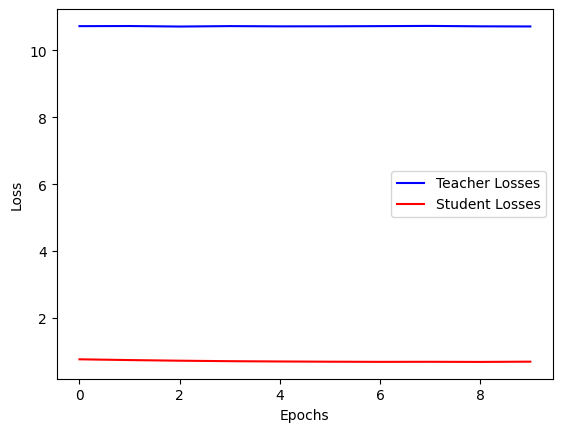

In [ ]:
plt.plot(teacher_losses, label='Teacher Losses', color='blue')
plt.plot(student_losses, label='Student Losses', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

^^ why student performed better? lower loss, but training loop does not show many improvements in both teach and student performance

__Changes:__

Added a cosine annealing learning rate scheduler to help in better convergence.

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)


100%|██████████| 170498071/170498071 [00:04<00:00, 39964156.87it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:

teacher = models.resnet18(pretrained=True).to(device)
student = models.resnet18(pretrained=False).to(device)


In [ ]:
optimizer = optim.Adam(student.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)  # Adjust T_max as per epochs


In [ ]:
# Temperature Scheduler
initial_temperature = 20.0
alpha = 0.9


In [ ]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).sum().item()
    return correct / labels.size(0)

In [ ]:
initial_temperature = 20.0
alpha = 0.9

def knowledge_distillation_loss(outputs, labels, teacher_outputs, temp, alpha):
    return nn.KLDivLoss(reduction='batchmean')(F.log_softmax(outputs/temp, dim=1),
                                               F.softmax(teacher_outputs/temp, dim=1)) * (alpha * temp * temp) + \
           F.cross_entropy(outputs, labels) * (1. - alpha)


In [ ]:
# Training Loop
epochs = 10
teacher_losses = []
student_losses = []
teacher_accuracies = []
student_accuracies = []



for epoch in range(epochs):
    student.train()
    teacher.eval()

    epoch_student_loss = 0.0
    epoch_teacher_loss = 0.0
    epoch_teacher_accuracy = 0.0
    epoch_student_accuracy = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        teacher_outputs = teacher(inputs).detach()
        student_outputs = student(inputs)

        loss = knowledge_distillation_loss(student_outputs, labels, teacher_outputs, initial_temperature, alpha)
        epoch_student_loss += loss.item()

        teacher_loss = F.cross_entropy(teacher_outputs, labels)
        epoch_teacher_loss += teacher_loss.item()

        epoch_teacher_accuracy += calculate_accuracy(teacher_outputs, labels)
        epoch_student_accuracy += calculate_accuracy(student_outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()

    teacher_losses.append(epoch_teacher_loss / len(train_loader))
    student_losses.append(epoch_student_loss / len(train_loader))
    teacher_accuracies.append(epoch_teacher_accuracy / len(train_loader))
    student_accuracies.append(epoch_student_accuracy / len(train_loader))

    initial_temperature *= alpha

    print(f"Epoch [{epoch+1}/{epochs}] Student Loss: {epoch_student_loss/len(train_loader):.4f}, Teacher Loss: {epoch_teacher_loss/len(train_loader):.4f}")



Epoch [1/10] Student Loss: 1.1442, Teacher Loss: 10.7290
Epoch [2/10] Student Loss: 0.9613, Teacher Loss: 10.7198
Epoch [3/10] Student Loss: 0.8621, Teacher Loss: 10.7316
Epoch [4/10] Student Loss: 0.7879, Teacher Loss: 10.7248
Epoch [5/10] Student Loss: 0.7428, Teacher Loss: 10.7204
Epoch [6/10] Student Loss: 0.7416, Teacher Loss: 10.7256
Epoch [7/10] Student Loss: 0.7452, Teacher Loss: 10.7209
Epoch [8/10] Student Loss: 0.7703, Teacher Loss: 10.7172
Epoch [9/10] Student Loss: 0.7957, Teacher Loss: 10.7301
Epoch [10/10] Student Loss: 0.8005, Teacher Loss: 10.7206


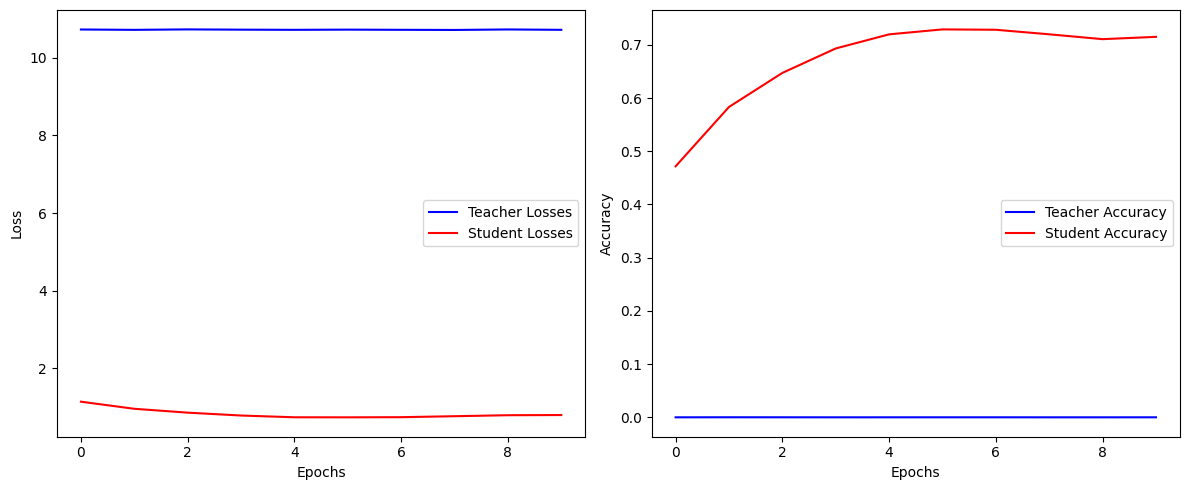

In [ ]:
# Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(teacher_losses, label='Teacher Losses', color='blue')
plt.plot(student_losses, label='Student Losses', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(teacher_accuracies, label='Teacher Accuracy', color='blue')
plt.plot(student_accuracies, label='Student Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
